# Long Short-Term Memory (LSTM) para Análisis de Series de Tiempo

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose

In [189]:
tf.random.set_seed(21562)

# Preparación de datos

Cargamos los datos

In [190]:
df = pd.read_csv('data/precios.csv', parse_dates=['Fecha'], index_col='Fecha')

In [191]:
df.head()

,Super,Regular,Diesel
Fecha,,,
2002-01-01,12.55,12.19,8.95
2002-02-01,12.29,11.90,8.66
2002-03-01,12.58,12.17,8.69
2002-04-01,14.11,13.71,9.38
2002-05-01,14.16,13.79,9.44


Visualización de los datos

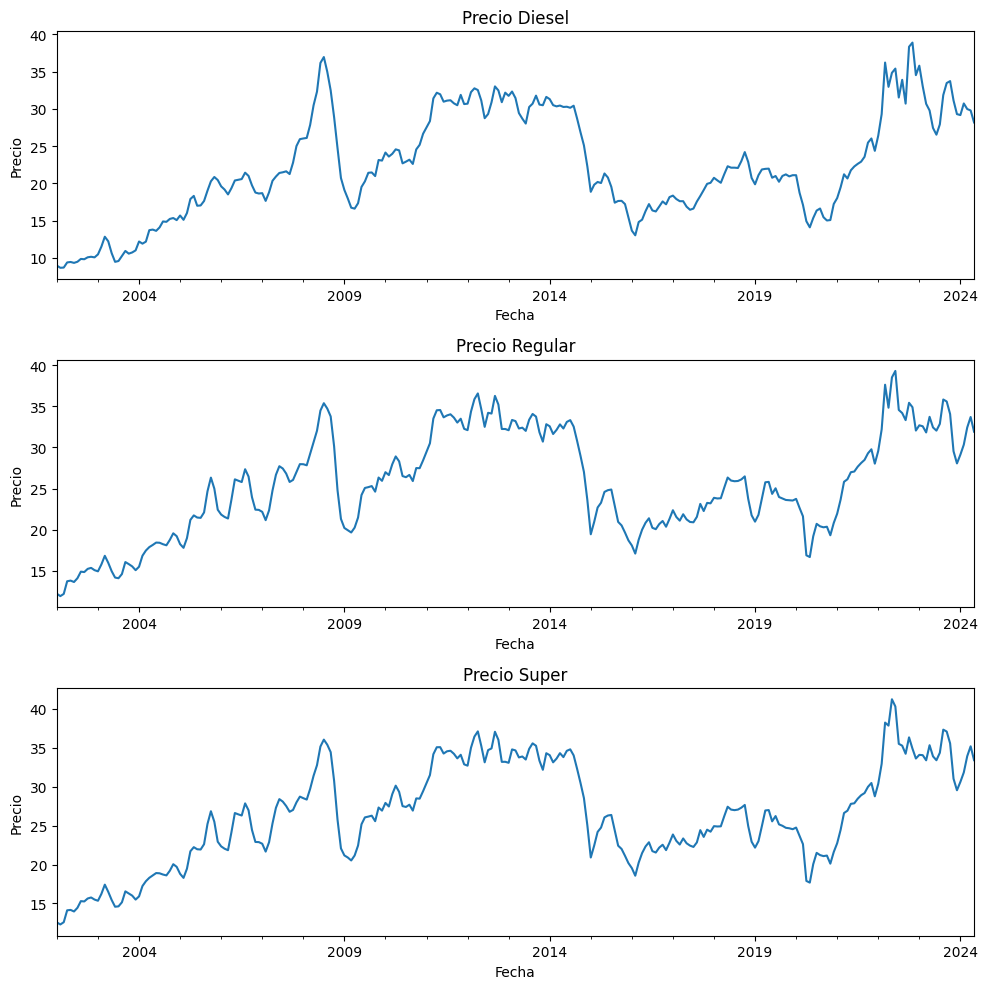

In [192]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

plt.show()

Descompocisión de la serie de tiempo

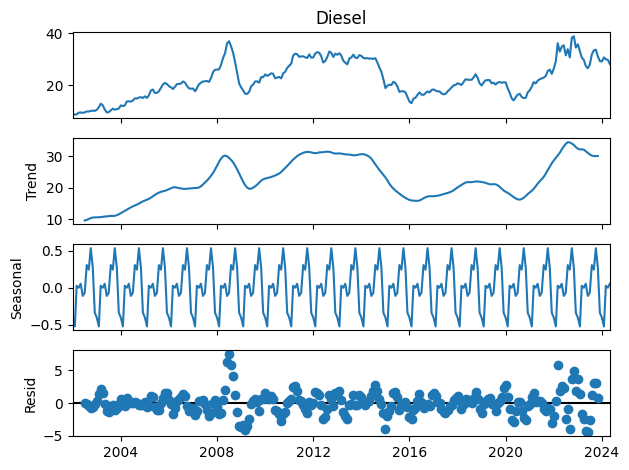

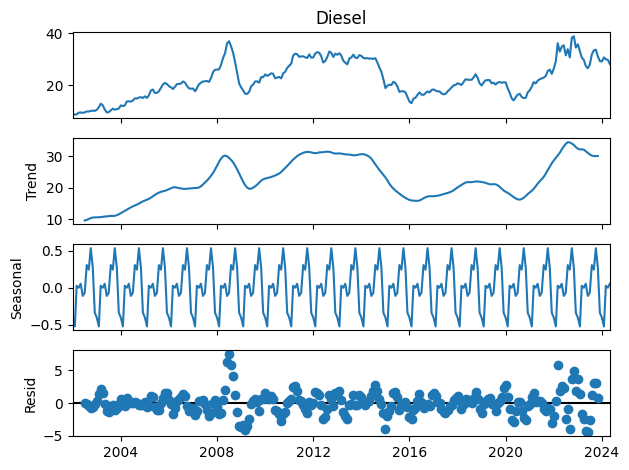

In [193]:
seasonal_decompose(df['Diesel'], model='additive', period=12).plot()

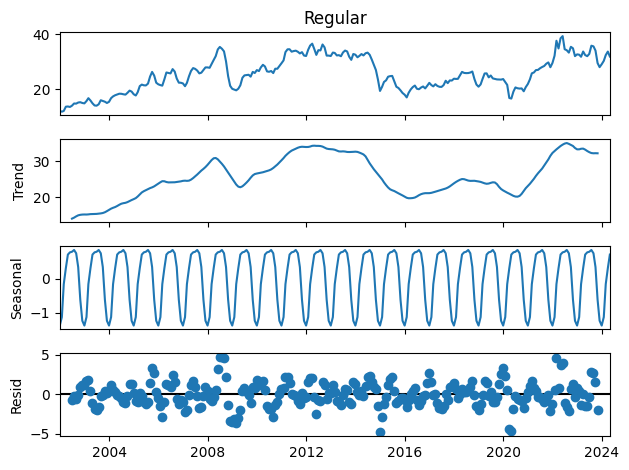

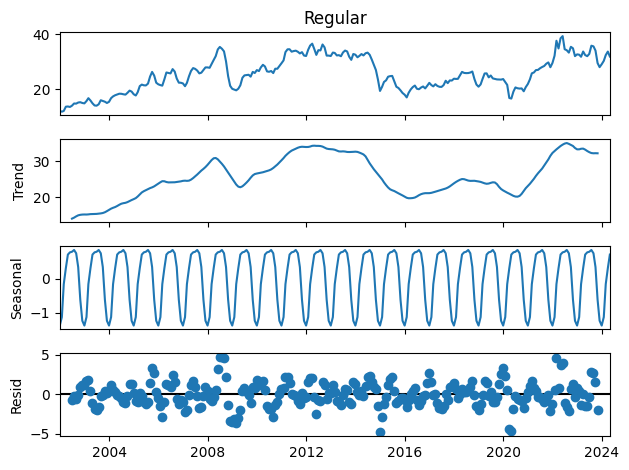

In [194]:
seasonal_decompose(df['Regular'], model='additive', period=12).plot()

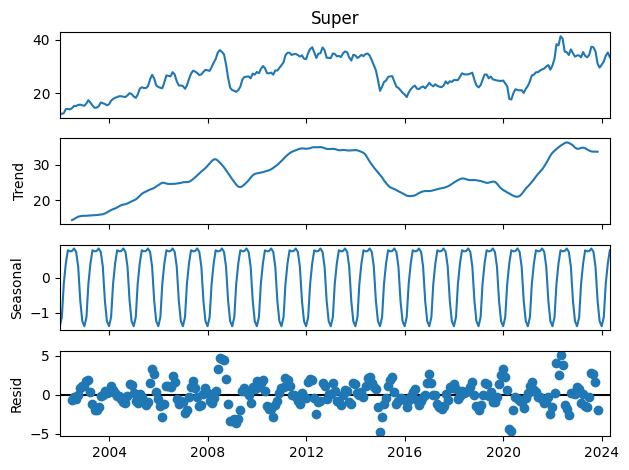

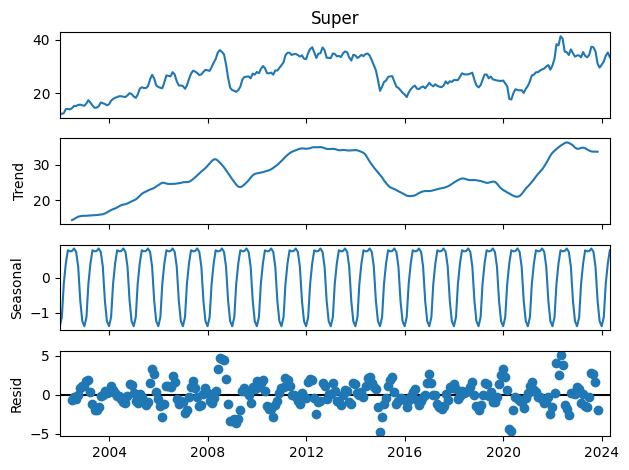

In [195]:
seasonal_decompose(df['Super'], model='additive', period=12).plot()

Diferenciación de la serie de tiempo

In [196]:
df['Diesel_diff'] = df['Diesel'].diff()

In [197]:
df['Regular_diff'] = df['Regular'].diff()

In [198]:
df['Super_diff'] = df['Super'].diff()

Eliminamos los valores nulos

In [199]:
df.dropna(inplace=True)

In [200]:
df.head()

,Super,Regular,Diesel,Diesel_diff,Regular_diff,Super_diff
Fecha,,,,,,
2002-02-01,12.29,11.90,8.66,-0.29,-0.29,-0.26
2002-03-01,12.58,12.17,8.69,0.03,0.27,0.29
2002-04-01,14.11,13.71,9.38,0.69,1.54,1.53
2002-05-01,14.16,13.79,9.44,0.06,0.08,0.05
2002-06-01,13.96,13.62,9.32,-0.12,-0.17,-0.20


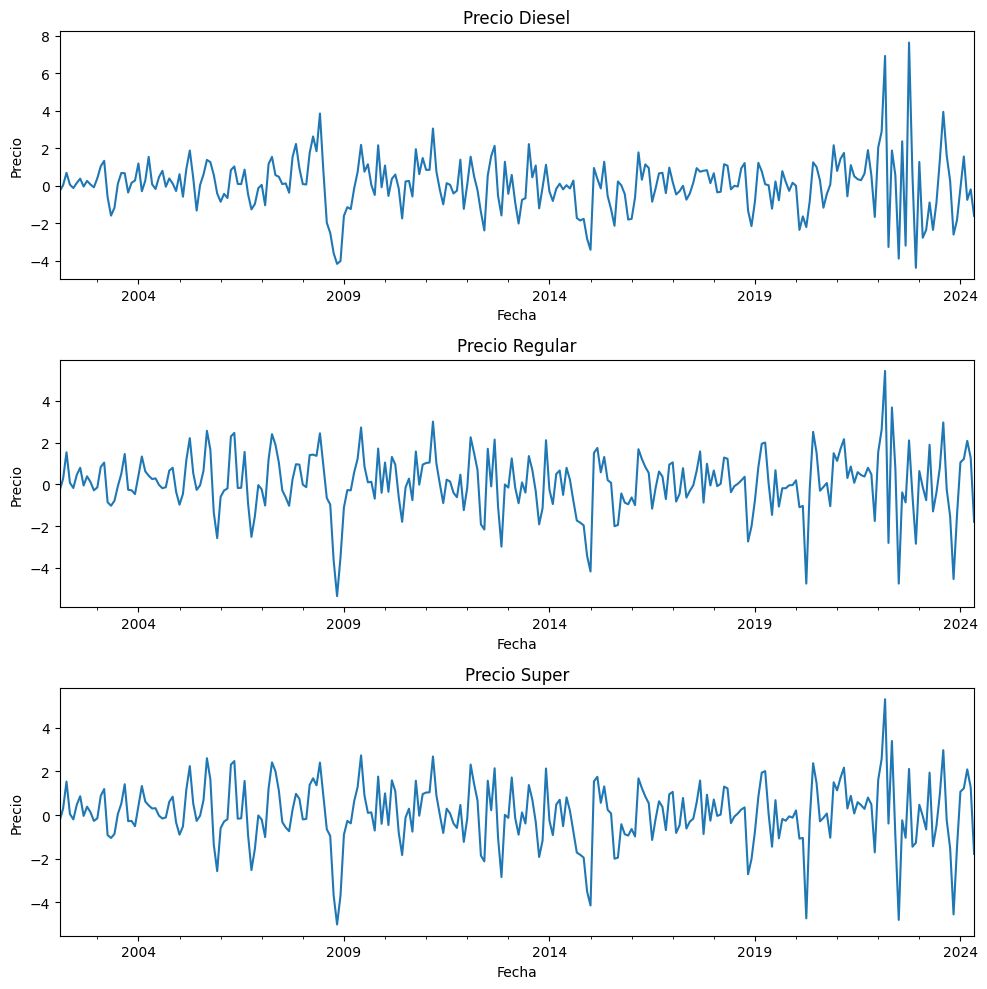

In [201]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel_diff'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular_diff'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super_diff'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

Normalización de los datos

In [202]:
scaler = MinMaxScaler(
    feature_range=(0, 1)
)

In [203]:
diesel_data = df['Diesel_diff'].values.reshape(-1, 1)
diesel_data = scaler.fit_transform(diesel_data)

In [204]:
regular_data = df['Regular_diff'].values.reshape(-1, 1)
regular_data = scaler.fit_transform(regular_data)

In [205]:
super_data = df['Super_diff'].values.reshape(-1, 1)
super_data = scaler.fit_transform(super_data)

Creación de secuencias

In [206]:
def create_sequences(data, seq_length=1, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Crea secuencias de datos "supervisados". Se crea una matriz bidimensional donde la dimennsión 0 es t-1 y la dimensión 1 es t.
    :param data: 
    :param seq_length: 
    :return: 
    """
    train_idx = int(len(data) * train_size)
    val_idx = int(len(data) * (train_size + val_size))

    train_data = data[:train_idx]
    val_data = data[train_idx:val_idx]
    test_data = data[val_idx:]

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for i in range(seq_length, len(train_data)):
        X_train.append(train_data[i - seq_length:i, 0])
        y_train.append(train_data[i, 0])

    for i in range(seq_length, len(val_data)):
        X_val.append(val_data[i - seq_length:i, 0])
        y_val.append(val_data[i, 0])

    for i in range(seq_length, len(test_data)):
        X_test.append(test_data[i - seq_length:i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [207]:
diesel_split = create_sequences(diesel_data)

X_train_diesel = diesel_split[0]
y_train_diesel = diesel_split[1]
X_val_diesel = diesel_split[2]
y_val_diesel = diesel_split[3]
X_test_diesel = diesel_split[4]
y_test_diesel = diesel_split[5]

In [208]:
regular_split = create_sequences(regular_data)

X_train_regular = regular_split[0]
y_train_regular = regular_split[1]
X_val_regular = regular_split[2]
y_val_regular = regular_split[3]
X_test_regular = regular_split[4]
y_test_regular = regular_split[5]

In [209]:
super_split = create_sequences(super_data)

X_train_super = super_split[0]
y_train_super = super_split[1]
X_val_super = super_split[2]
y_val_super = super_split[3]
X_test_super = super_split[4]
y_test_super = super_split[5]

## Modelo LSTM

### Versión 1

#### Diesel

In [210]:
model_diesel = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [211]:
model_diesel.compile(optimizer='adam', loss='mean_squared_error')

In [212]:
model_diesel.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [223]:
X_test_diesel.shape

(53, 1, 1)

In [213]:
history_diesel = model_diesel.fit(
    X_train_diesel,
    y_train_diesel,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_diesel, y_val_diesel),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.1390 - val_loss: 0.1009
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1013 - val_loss: 0.0670
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0674 - val_loss: 0.0375
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0386 - val_loss: 0.0157
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0181 - val_loss: 0.0056
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134 - val_loss: 0.0078
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0110 - val_loss: 0.0055
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0097 - val_loss: 0.0052
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_lo

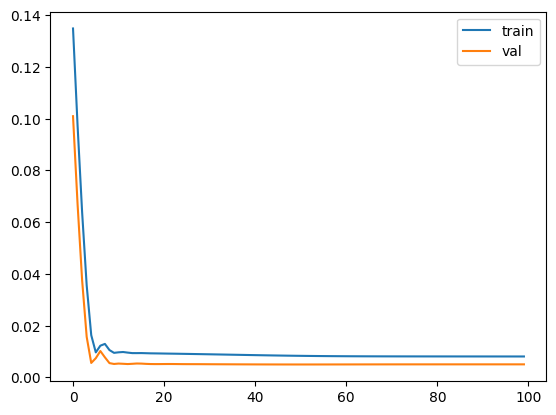

In [214]:
plt.plot(history_diesel.history['loss'], label='train')
plt.plot(history_diesel.history['val_loss'], label='val')
plt.legend()
plt.show()

In [215]:
y_pred_diesel = model_diesel.predict(X_test_diesel)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


In [216]:
y_pred_diesel = scaler.inverse_transform(y_pred_diesel)

In [217]:
y_test_diesel = scaler.inverse_transform(y_test_diesel.reshape(-1, 1))

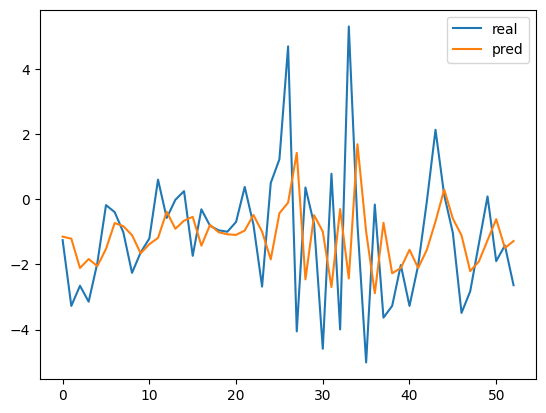

In [218]:
plt.plot(y_test_diesel, label='real')
plt.plot(y_pred_diesel, label='pred')
plt.legend()
plt.show()

#### Regular

In [224]:
model_regular = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [225]:
model_regular.compile(optimizer='adam', loss='mean_squared_error')

In [226]:
model_regular.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [227]:
history_regular = model_regular.fit(
    X_train_regular,
    y_train_regular,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_regular, y_val_regular),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.2521 - val_loss: 0.1963
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1948 - val_loss: 0.1422
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1403 - val_loss: 0.0911
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0892 - val_loss: 0.0469
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0462 - val_loss: 0.0169
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - val_loss: 0.0084
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - val_loss: 0.0151
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198 - val_loss: 0.0157
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - val_loss: 0.0106
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0146 - val_loss: 0.0084
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0135 - val_loss: 0.0085
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - val_loss:

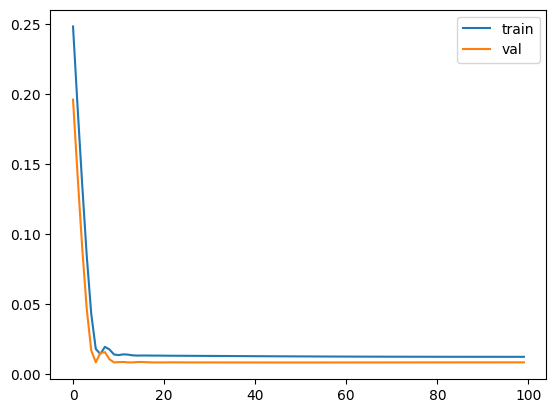

In [228]:
plt.plot(history_regular.history['loss'], label='train')
plt.plot(history_regular.history['val_loss'], label='val')
plt.legend()
plt.show()

In [229]:
y_pred_regular = model_regular.predict(X_test_regular)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


In [230]:
y_pred_regular = scaler.inverse_transform(y_pred_regular)

In [231]:
y_test_regular = scaler.inverse_transform(y_test_regular.reshape(-1, 1))

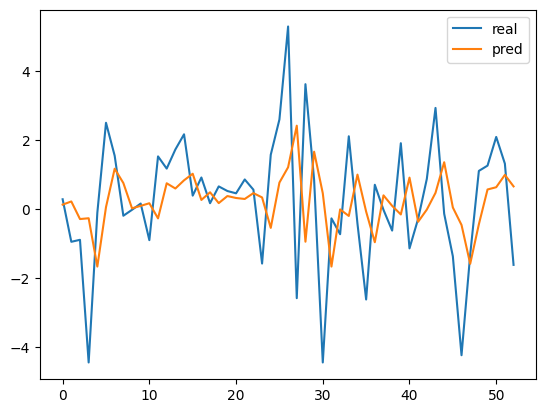

In [232]:
plt.plot(y_test_regular, label='real')
plt.plot(y_pred_regular, label='pred')
plt.legend()
plt.show()

#### Super

In [233]:
model_super = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

In [234]:
model_super.compile(optimizer='adam', loss='mean_squared_error')

In [235]:
model_super.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
history_super = model_super.fit(
    X_train_super,
    y_train_super,
    epochs=100,
    batch_size=36,
    validation_data=(X_val_super, y_val_super),
    verbose=1
)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.2493 - val_loss: 0.1994
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2025 - val_loss: 0.1541
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1561 - val_loss: 0.1090
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1100 - val_loss: 0.0664
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0671 - val_loss: 0.0313
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0331 - val_loss: 0.0114
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - val_loss: 0.0111
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0170 - val_loss: 0.0170
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0179 - val_loss: 0.0101
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0150 - val_loss: 0.0091
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0149 - val_los

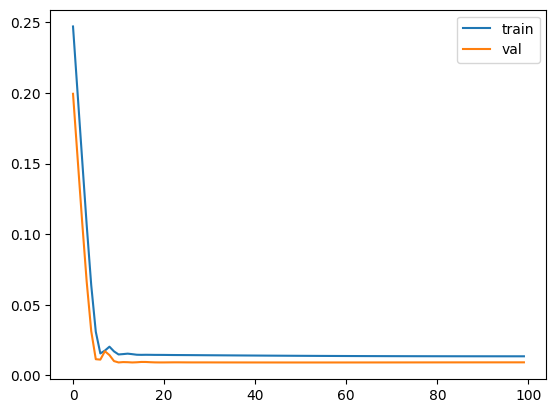

In [237]:
plt.plot(history_super.history['loss'], label='train')
plt.plot(history_super.history['val_loss'], label='val')
plt.legend()
plt.show()

In [238]:
y_pred_super = model_super.predict(X_test_super)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step


In [239]:
y_pred_super = scaler.inverse_transform(y_pred_super)

In [240]:
y_test_super = scaler.inverse_transform(y_test_super.reshape(-1, 1))

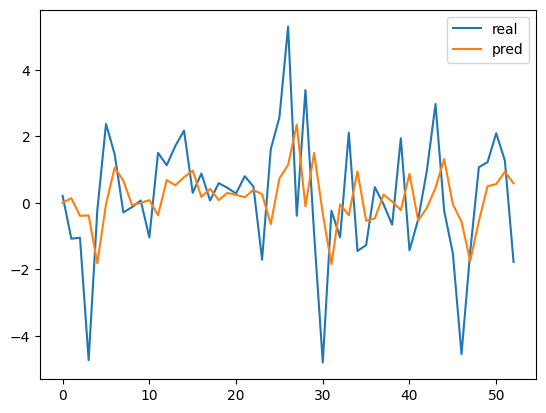

In [241]:
plt.plot(y_test_super, label='real')
plt.plot(y_pred_super, label='pred')
plt.legend()
plt.show()